# Simulation of a Turbo encoder and decoder

In this example we will show how to use the Turbo encoder/decoder class in py-itpp. The Turbo codec used here is quite close to the LTE specification, however, implementation details related to tails have been left out for simplicity. 

In [1]:
# Imports
import itpp
from matplotlib import pyplot as plt

#  Set up the Turbo encoder/decoder class

In [2]:
turbo_codec = itpp.comm.turbo_codec()

generator_sequence = itpp.ivec('11, 13')
constraint_length = 4
block_size = 512

# Set coded parameters
turbo_codec.set_parameters(generator_sequence, generator_sequence, constraint_length, itpp.ivec())

# The interleaver is generate based on a Quadrature Permutation Polynomial (QPP)
# Defined in 
f1 = 31
f2 = 64
interleaver_sequence = itpp.ivec(block_size)
for i in range(block_size):
    interleaver_sequence.set(i, (f1 * i + f2 * i * i) % block_size)

turbo_codec.set_interleaver(interleaver_sequence)

# Find out the channel code rate
dummy_bits = itpp.randb(block_size)
coded_bits = itpp.bvec()
turbo_codec.encode(dummy_bits, coded_bits)

coded_block_length = coded_bits.length()
rate = block_size / coded_block_length

print('Channel code rate: %0.4f'%(rate))

Channel code rate: 0.3307


# Initialize modulator, channel, and block error counter
In this example we simulate quadrature amplitude modulation (QAM) with 4 constellation points in the complex domain. The channel is additive white gaussian noise (AWGN) normalized to unit power here, and updated in later section for each simulated EbN0.

In [3]:
# Initialize QAM modulator
qam = itpp.comm.QAM(M=4)

# Initialize an AWGN channel
channel = itpp.comm.AWGN_Channel(noisevar=0)

# Initialize block error counter
blerc = itpp.comm.BLERC(block_size)

# Set up some simulation specific parameters

In [4]:
EbN0_dB = itpp.vec('0:1:5')

energy_per_bit = 1.0 / rate

nrof_blocks = 100 # Number of blocks in each iteration
max_iterations = 10 
max_errors = 10

bler = itpp.vec(EbN0_dB.length()) # Bit error rate
bler.clear()

# Randomize the random number generators
itpp.random.RNG_reset(42)

# Run the simulation

In [10]:
coded_bits = itpp.bvec()
transmitted_symbols = itpp.cvec()
for p in range(EbN0_dB.length()):
    print('Now simulating point %d out of %d with EbN0_dB = %.2f'%(p + 1, EbN0_dB.length(), EbN0_dB[p]))
    blerc.clear()  # Clear the bit error rate counter.
    
    noise_var = energy_per_bit / 10 ** (0.1 * EbN0_dB[p])
    channel.set_noise(noise_var)  # Set the noise value of the AWGN channel.
    for i in range(max_iterations):
      uncoded_bits = itpp.randb(nrof_blocks * block_size) 
      turbo_codec.encode(uncoded_bits, coded_bits)
        
      qam.modulate_bits(coded_bits, transmitted_symbols)
      received_symbols = channel(transmitted_symbols)
    
      soft_values = qam.demodulate_soft_bits(received_symbols, noise_var, itpp.comm.Soft_Method.LOGMAP)
        
      decoded_bits = itpp.bvec()
      turbo_codec.decode(soft_values, decoded_bits, itpp.bvec())
      blerc.count(uncoded_bits, decoded_bits)
          
      bler[p] = blerc.get_errorrate()
      
      # Break the simulation on this point if sufficient number of bit errors were observed
      if (blerc.get_errors() > max_errors):
        print('Breaking on point %d with %d block errors'%(p + 1, blerc.get_errors()))
        break

Now simulating point 1 out of 6 with EbN0_dB = 0.00
Breaking on point 1 with 100 block errors
Now simulating point 2 out of 6 with EbN0_dB = 1.00
Breaking on point 2 with 100 block errors
Now simulating point 3 out of 6 with EbN0_dB = 2.00
Breaking on point 3 with 100 block errors
Now simulating point 4 out of 6 with EbN0_dB = 3.00
Breaking on point 4 with 92 block errors
Now simulating point 5 out of 6 with EbN0_dB = 4.00
Breaking on point 5 with 16 block errors
Now simulating point 6 out of 6 with EbN0_dB = 5.00


In [11]:
print(bler)
print(EbN0_dB)

[1 1 1 0.92 0.08 0]
[0 1 2 3 4 5]


# Plot results

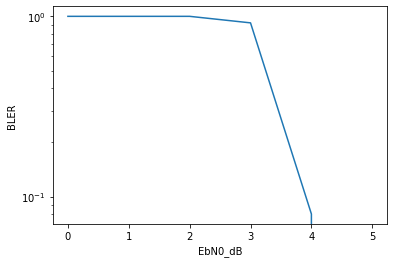

In [12]:
import numpy as np

#Plot the results:
plt.figure()
plt.semilogy( np.array( EbN0_dB ), np.array( bler ))
plt.xlabel('EbN0_dB')
plt.ylabel('BLER')
plt.show()